In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy.ma as ma
import numpy
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.cm as cm
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from palettable import colorbrewer
import numpy as np


def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError( "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


In [2]:
adir='F:/data/cruise_data/saildrone/baja-2018/'
#adir='C:/Users/gentemann/Desktop/data/'
fname=adir+'saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1_withloggers.nc'
#fname=adir+'saildrone-gen_4-baja_2018-EP-sd1002-ALL-1_min-v1_with_loggers.nc'
ds=xr.open_dataset(fname)
ds = ds.isel(trajectory=0)
lons_usv=ds.longitude
lats_usv=ds.latitude
time_usv=ds.time
ds = ds.swap_dims({'obs':'time'})
ds = ds.sel(time=slice('2018-04-12T02','2018-06-10T18'))

#dstem.sel(**{'time':slice('2018-05-01','2018-05-02')})

In [3]:
ds['spd']=np.sqrt(ds.UWND_MEAN**2+ds.VWND_MEAN**2)

In [6]:
xlon = ds.longitude.interpolate_na('time')
ds

<xarray.Dataset>
Dimensions:                               (time: 85980)
Coordinates:
    trajectory                            float32 1002.0
  * time                                  (time) datetime64[ns] 2018-04-12T02:00:00 ... 2018-06-10T18:59:00
    latitude                              (time) float64 ...
    longitude                             (time) float64 ...
Data variables:
    SOG                                   (time) float64 ...
    COG                                   (time) float64 ...
    HDG                                   (time) float64 ...
    HDG_WING                              (time) float64 ...
    ROLL                                  (time) float64 ...
    PITCH                                 (time) float64 ...
    WING_ANGLE                            (time) float64 ...
    BARO_PRES_MEAN                        (time) float64 ...
    BARO_PRES_STDDEV                      (time) float64 ...
    TEMP_AIR_MEAN                         (time) float64 ...
 

In [7]:
#subset = ds.where(((ds.time.dt.hour>12)|(ds.time.dt.hour<6))&(ds.spd<7.5))
ds['tdif'] = ds.sea_water_temperature_logger1_mean-ds.sea_water_temperature_logger4_mean
ds['tdif1'] = ds.sea_water_temperature_logger1_mean-ds.sea_water_temperature_logger3_mean
ds['tdif2'] = ds.sea_water_temperature_logger1_mean-ds.sea_water_temperature_logger2_mean
ds['tdif3'] = ds.sea_water_temperature_logger1_mean-ds.sea_water_temperature_logger1_mean
ds['tdif_ctd'] = ds.sea_water_temperature_logger1_mean-ds.TEMP_CTD_MEAN
ds['tdif_o2'] = ds.sea_water_temperature_logger1_mean-ds.TEMP_O2_MEAN
ds['tdif_both'] = ds.TEMP_O2_MEAN-ds.TEMP_CTD_MEAN
ds['tdif_ir'] = ds.TEMP_IR_UNCOR_MEAN-ds.TEMP_CTD_MEAN
subset = ds.where(np.logical_not((ds.time.dt.hour>12)&(ds.spd<7.5)))
subset = subset.where(np.logical_not((ds.time.dt.hour<6)&(ds.spd<7.5)))
subset = subset.where(np.logical_not((ds.time>np.datetime64('2018-05-24T12')) & (ds.time<np.datetime64('2018-05-26T12'))))

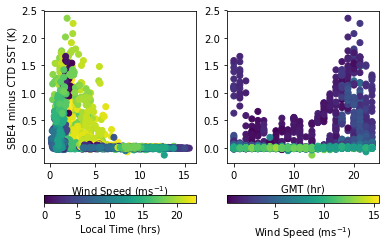

In [186]:
fig,(ax1,ax2) =plt.subplots(1,2)
cs=ax1.scatter(ds.spd,ds.tdif,c=ds.time.dt.hour)
ax1.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='SBE4 minus CTD SST (K)')
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('Local Time (hrs)')
cs2=ax2.scatter(ds.time.dt.hour,ds.tdif,c=ds.spd)
ax2.set(xlabel='GMT (hr)')
cbar = fig.colorbar(cs2,orientation='horizontal',ax=ax2)
cbar.set_label('Wind Speed (ms$^{-1}$)')
fig.savefig(adir+'figs/diurnal/temp_loggers_data.png')

(-0.05, 0.05)

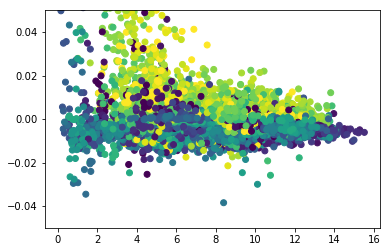

In [205]:
#plt.scatter(subset.spd,subset.tdif1,c=subset.time.dt.hour)
plt.scatter(ds.spd,ds.tdif1,c=ds.time.dt.hour)
plt.ylim(-.05, .05)

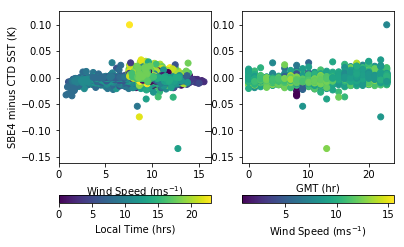

In [184]:
fig,(ax1,ax2) =plt.subplots(1,2)
cs=ax1.scatter(subset.spd,subset.tdif,c=subset.time.dt.hour)
ax1.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='SBE4 minus CTD SST (K)')
cbar = fig.colorbar(cs,orientation='horizontal',ax=ax1)
cbar.set_label('Local Time (hrs)')
cs2=ax2.scatter(subset.time.dt.hour,subset.tdif,c=subset.spd)
ax2.set(xlabel='GMT (hr)')
cbar = fig.colorbar(cs2,orientation='horizontal',ax=ax2)
cbar.set_label('Wind Speed (ms$^{-1}$)')
fig.savefig(adir+'figs/diurnal/temp_loggers_masked_data.png')


In [227]:
print(subset.tdif.mean().data,subset.tdif.std().data,np.isfinite(subset.tdif).sum().data)
print(subset.tdif1.mean().data,subset.tdif1.std().data,np.isfinite(subset.tdif1).sum().data)
print(subset.tdif2.mean().data,subset.tdif2.std().data,np.isfinite(subset.tdif2).sum().data)
print(subset.tdif3.mean().data,subset.tdif3.std().data,np.isfinite(subset.tdif3).sum().data)
print(subset.tdif_ctd.mean().data,subset.tdif_ctd.std().data,np.isfinite(subset.tdif_ctd).sum().data)
print(subset.tdif_o2.mean().data,subset.tdif_o2.std().data,np.isfinite(subset.tdif_o2).sum().data)
print(subset.tdif_ir.mean().data,subset.tdif_ir.std().data,np.isfinite(subset.tdif_ir).sum().data)



0.0 0.0 77708
-0.001496945616924892 0.01895270401274291 77708
-0.0027859351675503033 0.03548195048121021 77708
-0.0034322315591702184 0.07558567747356534 77708
0.0019025280294617997 0.042291102401226265 77478
-0.014016855537486241 0.041662191901573234 77478
-0.2123303505331377 0.2287127893749872 76997


((-0.08, 0.08), (0, 5))

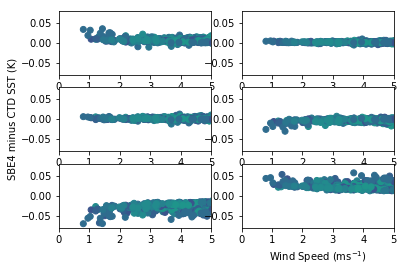

In [226]:
ds['tdif'] = ds.sea_water_temperature_logger4_mean-ds.sea_water_temperature_logger4_mean
ds['tdif1'] = ds.sea_water_temperature_logger4_mean-ds.sea_water_temperature_logger3_mean
ds['tdif2'] = ds.sea_water_temperature_logger4_mean-ds.sea_water_temperature_logger2_mean
ds['tdif3'] = ds.sea_water_temperature_logger4_mean-ds.sea_water_temperature_logger1_mean
ds['tdif_ctd'] = ds.sea_water_temperature_logger1_mean-ds.TEMP_CTD_MEAN
ds['tdif_o2'] = ds.sea_water_temperature_logger1_mean-ds.TEMP_O2_MEAN
ds['tdif_both'] = ds.TEMP_O2_MEAN-ds.TEMP_CTD_MEAN
ds['tdif_ir'] = ds.TEMP_IR_UNCOR_MEAN-ds.TEMP_CTD_MEAN
subset = ds.where(np.logical_not((ds.time.dt.hour>12)&(ds.spd<7.5)))
subset = subset.where(np.logical_not((ds.time.dt.hour<6)&(ds.spd<7.5)))
subset = subset.where(np.logical_not((ds.time>np.datetime64('2018-05-24T12')) & (ds.time<np.datetime64('2018-05-26T12'))))
fig,axes =plt.subplots(3,2)
ax=axes[0,0]
ax.scatter(subset.spd,subset.tdif3,c=subset.time.dt.hour)
#ax.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='SBE4 minus CTD SST (K)')
ax.set_ylim(-.08,0.08), ax.set_xlim(0,5)
ax=axes[0,1]
ax.scatter(subset.spd,subset.tdif1,c=subset.time.dt.hour)
#ax.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='SBE4 minus CTD SST (K)')
ax.set_ylim(-.08,0.08), ax.set_xlim(0,5)
ax=axes[1,0]
ax.scatter(subset.spd,subset.tdif2,c=subset.time.dt.hour)
ax.set(ylabel='SBE4 minus CTD SST (K)')
ax.set_ylim(-.08,0.08), ax.set_xlim(0,5)
ax=axes[1,1]
ax.scatter(subset.spd,subset.tdif_ctd,c=subset.time.dt.hour)
#ax.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='SBE4 minus CTD SST (K)')
ax.set_ylim(-.08,0.08), ax.set_xlim(0,5)
ax=axes[2,0]
ax.scatter(subset.spd,subset.tdif_o2,c=subset.time.dt.hour)
#ax.set(xlabel='Wind Speed (ms$^{-1}$)', ylabel='SBE4 minus CTD SST (K)')
ax.set_ylim(-.08,0.08), ax.set_xlim(0,5)
ax=axes[2,1]
ax.scatter(subset.spd,subset.tdif_both,c=subset.time.dt.hour)
ax.set(xlabel='Wind Speed (ms$^{-1}$)')
ax.set_ylim(-.08,0.08), ax.set_xlim(0,5)


0.0034322315591702184 0.07558567747356534 77708
0.0019352859422453277 0.06521465431396252 77708
0.000646296391619916 0.053982213769273216 77708
0.0 0.0 77708
0.0019025280294617997 0.042291102401226265 77478
-0.014016855537486241 0.041662191901573234 77478
-0.2123303505331377 0.2287127893749872 76997


0 -1.0 0
1 -0.98 0
2 -0.96 0
3 -0.94 0
4 -0.92 0
5 -0.9 0
6 -0.88 0
7 -0.86 0
8 -0.84 0
9 -0.8200000000000001 0
10 -0.8 0
11 -0.78 0
12 -0.76 1
13 -0.74 0
14 -0.72 0
15 -0.7 2
16 -0.6799999999999999 5
17 -0.6599999999999999 20
18 -0.64 43
19 -0.62 153
20 -0.6 528
21 -0.5800000000000001 1273
22 -0.56 2284
23 -0.54 2736
24 -0.52 2681
25 -0.5 2803
26 -0.48 2343
27 -0.45999999999999996 2533
28 -0.43999999999999995 2133
29 -0.42000000000000004 2101
30 -0.4 2012
31 -0.38 1816
32 -0.36 1513
33 -0.33999999999999997 1528
34 -0.31999999999999995 1349
35 -0.29999999999999993 1209
36 -0.28 1402
37 -0.26 1343
38 -0.24 1360
39 -0.21999999999999997 1408
40 -0.19999999999999996 1655
41 -0.17999999999999994 2340
42 -0.16000000000000003 2633
43 -0.14 2974
44 -0.12 2735
45 -0.09999999999999998 2895
46 -0.07999999999999996 3286
47 -0.05999999999999994 3733
48 -0.040000000000000036 3220
49 -0.020000000000000018 2949
50 0.0 2785
51 0.020000000000000018 1694
52 0.040000000000000036 855
53 0.06000000000000005

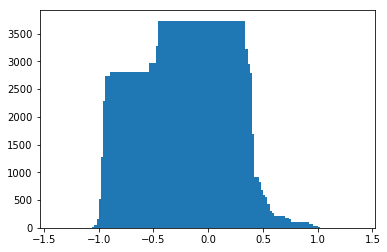

In [170]:
#subset.tdif_ir.plot()
h,xbin = np.histogram(subset.tdif_ir,bins=100,range=(-1,1))
plt.bar(xbin[:-1],h)
for i in range(100):
    print(i,xbin[i],h[i])

array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
       -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
       -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
       -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
       -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12,
       -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
        0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,
        0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,
        0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,
        0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,
        0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,
        0.98,  1.  ])

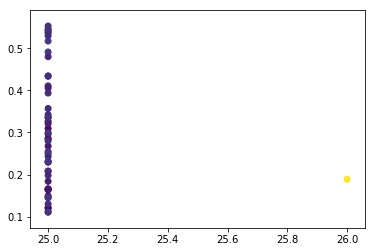

In [114]:
ds_warm = subset.where(subset.tdif>.1)
plt.scatter(ds_warm.time.dt.day,ds_warm.tdif,c=ds_warm.spd)
#plt.scatter(ds_warm.time.dt.hour,ds_warm.tdif,c=ds_warm.spd)
#plt.plot(ds_warm.time,ds_warm.tdif2,'r.')
#plt.scatter(subset.time.dt.hour,subset.tdif,c=subset.spd)

(-0.05, 3)

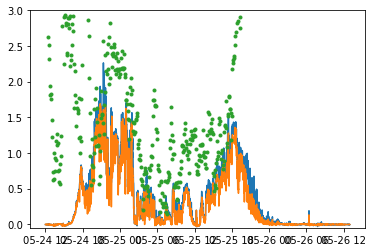

In [124]:
subset1 = ds.sel(time=slice('2018-05-24T12','2018-05-26T12'))
plt.plot(subset1.time,subset1.tdif)
plt.plot(subset1.time,subset1.tdif2)
plt.plot(subset1.time,subset1.spd,'.')
plt.ylim(-.05,3)

In [125]:
subset1 = subset.where(subset.time=slice('2018-05-24T12','2018-05-26T12'))
plt.plot(subset1.time,subset1.tdif)
plt.plot(subset1.time,subset1.tdif2)


SyntaxError: keyword can't be an expression (<ipython-input-125-013960d5e173>, line 1)

In [94]:
z=[-0.295,-0.6,-0.985,-1.42,-1.785]
time_offset_to_lmt=(xlon[0,:]/360.)*24.*60.*60.
#print(time_offset_to_lmt)
tlmt= time_usv+time_offset_to_lmt*dt.timedelta(seconds=1)
i1save=[12800,35800,46000,61400,62080]
i2save=[13300,36300,46700,62080,63400]
file_str=['p1','p2','p3','p4','p5','p6','p7']
ilen=len(i1save)
#resample data to 30 min averages
t1_ave = xr.DataArray(ds.sea_water_temperature_logger1_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='30min').mean()
t2_ave = xr.DataArray(ds.TEMP_CTD_MEAN[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='30min').mean()
t3_ave = xr.DataArray(ds.sea_water_temperature_logger2_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='30min').mean()
t4_ave = xr.DataArray(ds.sea_water_temperature_logger3_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='30min').mean()
t5_ave = xr.DataArray(ds.sea_water_temperature_logger4_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='30min').mean()
ilen_ave=len(t1_ave)
tdata=np.ones([ilen_ave,5])
for i in range(0,ilen_ave):
    tdata[i,0]=t1_ave[i]-t5_ave[i]
    tdata[i,1]=t2_ave[i]-(t5_ave[i]) #-273.15)
    tdata[i,2]=t3_ave[i]-t5_ave[i]
    tdata[i,3]=t4_ave[i]-t5_ave[i]
    tdata[i,4]=t5_ave[i]-t5_ave[i]
#create xarray structure
profiles = xr.DataArray(tdata, coords={'time': t1_ave.time,'depth':z}, dims=('time','depth'))


IndexError: too many indices

In [8]:
#create profiles at 1 min as well
z=[-0.295,-0.6,-0.985,-1.42,-1.785]
time_offset_to_lmt=(xlon[0,:]/360.)*24.*60.*60.
#print(time_offset_to_lmt)
tlmt= time_usv+time_offset_to_lmt*dt.timedelta(seconds=1)
i1save=[12800,35800,46000,61400,62080]
i2save=[13300,36300,46700,62080,63400]
file_str=['p1','p2','p3','p4','p5','p6','p7']
ilen=len(i1save)
#resample data to 30 min averages
t1_ave = xr.DataArray(ds.sea_water_temperature_logger1_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='1min').mean()
t2_ave = xr.DataArray(ds.TEMP_CTD_MEAN[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='1min').mean()
t3_ave = xr.DataArray(ds.sea_water_temperature_logger2_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='1min').mean()
t4_ave = xr.DataArray(ds.sea_water_temperature_logger3_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='1min').mean()
t5_ave = xr.DataArray(ds.sea_water_temperature_logger4_mean[0,:], coords={'time': tlmt.values}, dims=('time')).resample(time='1min').mean()
ilen_ave=len(t1_ave)
tdata=np.ones([ilen_ave,5])
for i in range(0,ilen_ave):
    tdata[i,0]=t1_ave[i]-t5_ave[i]
    tdata[i,1]=t2_ave[i]-(t5_ave[i]) #-273.15)
    tdata[i,2]=t3_ave[i]-t5_ave[i]
    tdata[i,3]=t4_ave[i]-t5_ave[i]
    tdata[i,4]=t5_ave[i]-t5_ave[i]
#create xarray structure
profiles_1min = xr.DataArray(tdata, coords={'time': t1_ave.time,'depth':z}, dims=('time','depth'))


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [125]:
#check the NEDT
#smooth by 10 minutes using hanning window
#calculate STD on temp - smoothed(temp)
t=ds.time[0,:]
s1=ds.sea_water_temperature_logger1_mean[0,:]
s2=smooth(s1,10)
d=s1-s2[5:-4]
print(d.std(ddof=1))
t=ds.time[0,:]
s1=ds.sea_water_temperature_logger2_mean[0,:]
s2=smooth(s1,10)
d=s1-s2[5:-4]
print(d.std(ddof=1))
t=ds.time[0,:]
s1=ds.sea_water_temperature_logger3_mean[0,:]
s2=smooth(s1,10)
d=s1-s2[5:-4]
print(d.std(ddof=1))
t=ds.time[0,:]
s1=ds.sea_water_temperature_logger4_mean[0,:]
s2=smooth(s1,10)
d=s1-s2[5:-4]
print(d.std(ddof=1))
t=ds.time[0,:]
s1=ds.TEMP_CTD_MEAN[0,:]
s2=smooth(s1,10)
d=s1-s2[5:-4]
print(d.std(ddof=1))

<xarray.DataArray 'sea_water_temperature_logger1_mean' ()>
array(0.015774)
Coordinates:
    trajectory  float32 1002.0
<xarray.DataArray 'sea_water_temperature_logger2_mean' ()>
array(0.015845)
Coordinates:
    trajectory  float32 1002.0
<xarray.DataArray 'sea_water_temperature_logger3_mean' ()>
array(0.016094)
Coordinates:
    trajectory  float32 1002.0
<xarray.DataArray 'sea_water_temperature_logger4_mean' ()>
array(0.016586)
Coordinates:
    trajectory  float32 1002.0
<xarray.DataArray 'TEMP_CTD_MEAN' ()>
array(0.015807)
Coordinates:
    trajectory  float32 1002.0


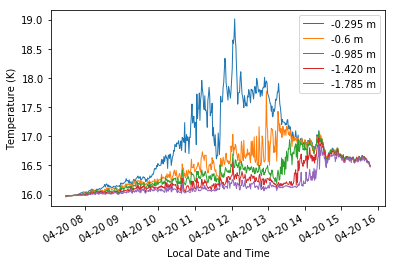

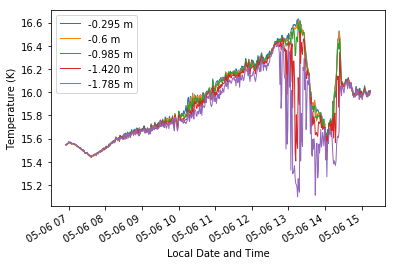

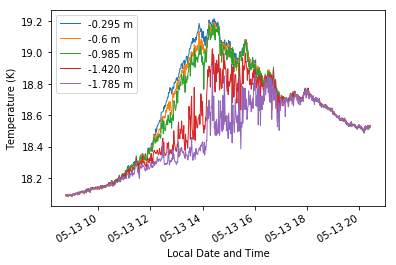

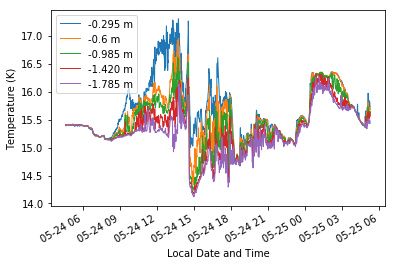

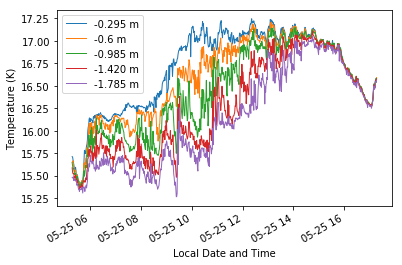

In [9]:
#make plots of times with diurnal warming, PLOT LOCAL TIME
time_offset_to_lmt=(xlon[0,:]/360.)*24.*60.*60.
tlmt= ds.time[0,:]+time_offset_to_lmt* dt.timedelta(seconds=1)
i1save=[12800,35800,46000,61600,63080]
i2save=[13300,36300,46700,63080,63800]
file_str=['p1','p2','p3','p4','p5','p6','p7']
ilen=len(i1save)
for ii in range(0,ilen):
    i1=i1save[ii]
    i2=i2save[ii]
#    t=ds.TIME[0,:].isel(obs=slice(i1,i2)) #UTC time
    t=tlmt.isel(obs=slice(i1,i2)) #local time
    s0=ds.TEMP_CTD_MEAN[0,:].isel(obs=slice(i1,i2))
    s1=ds.sea_water_temperature_logger1_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s2=ds.sea_water_temperature_logger2_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s3=ds.sea_water_temperature_logger3_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s4=ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s0mask = np.isfinite(s0)
    s1mask = np.isfinite(s1)
    s2mask = np.isfinite(s2)
    s3mask = np.isfinite(s3)
    s4mask = np.isfinite(s4)

    fig, ax = plt.subplots()
    ax.plot_date(t[s1mask], s1[s1mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s0mask], s0[s0mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s2mask], s2[s2mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s3mask], s3[s3mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s4mask], s4[s4mask],'-',markersize=.5,lw=1)
    ax.set(xlabel='Local Date and Time', ylabel='Temperature (K)')
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    #ax.fmt_xdata = t.DateFormatter('%Y-%m-%d')
    tem=str(ds.TEMP_CTD_MEAN.installed_height)+' m'
    ax.legend([ds.sea_water_temperature_logger1_mean.installed_height,tem,ds.sea_water_temperature_logger2_mean.installed_height,ds.sea_water_temperature_logger3_mean.installed_height,ds.sea_water_temperature_logger4_mean.installed_height])
    fig.savefig(adir+'figs/diurnal/temp_loggers_'+file_str[ii]+'.png')
    plt.show()


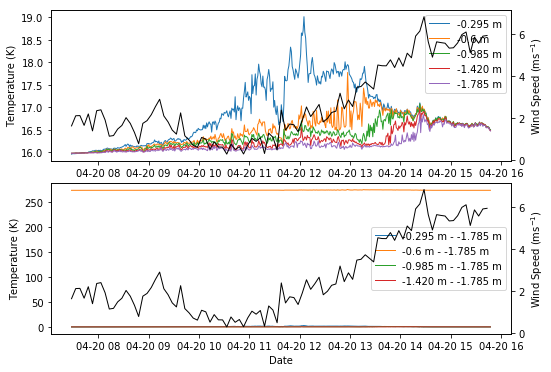

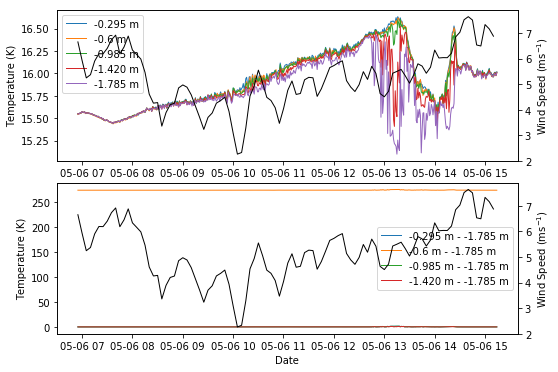

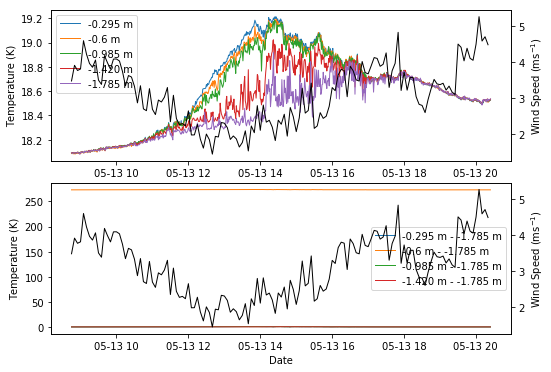

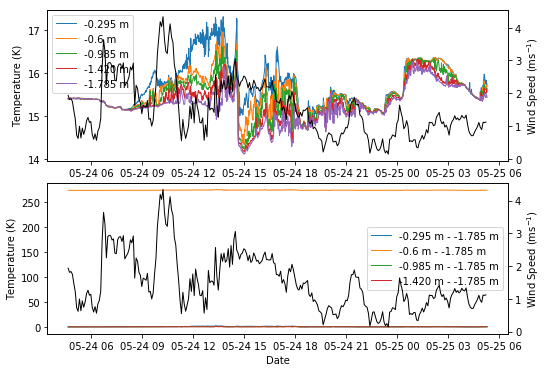

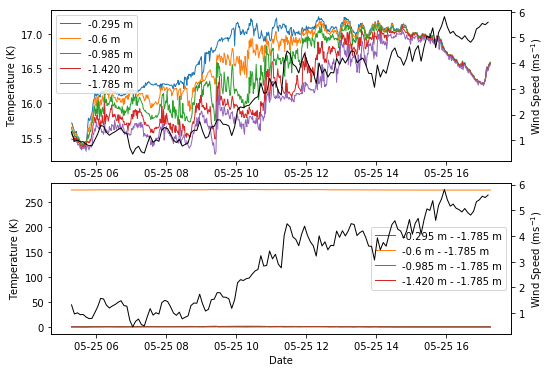

In [10]:
#make plots of times with diurnal warming
#add wind speed to figure
i1save=[12800,35800,46000,61600,63080]
i2save=[13300,36300,46700,63080,63800]
ilen_str=['p1','p2','p3','p4','p5','p6','p7']
ilen=len(i1save)
for ii in range(0,ilen):
    i1=i1save[ii]
    i2=i2save[ii]
#    t=ds.TIME[0,:].isel(obs=slice(i1,i2)) #UTC time
    t=tlmt.isel(obs=slice(i1,i2)) #local time
    tem2=(tlmt[i1].values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
    tem3=datetime.utcfromtimestamp(tem2)
    day_of_year = tem3.timetuple().tm_yday

    s0=ds.TEMP_CTD_MEAN[0,:].isel(obs=slice(i1,i2))
    s1=ds.sea_water_temperature_logger1_mean[0,:].isel(obs=slice(i1,i2)) #-273.15
    s2=ds.sea_water_temperature_logger2_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s3=ds.sea_water_temperature_logger3_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s4=ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    wnd=(ds.UWND_MEAN[0,:].isel(obs=slice(i1,i2))**2+ds.VWND_MEAN[0,:].isel(obs=slice(i1,i2))**2)**.5
    s0mask = np.isfinite(s0)
    s1mask = np.isfinite(s1)
    s2mask = np.isfinite(s2)
    s3mask = np.isfinite(s3)
    s4mask = np.isfinite(s4)
    wmask = np.isfinite(wnd)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0.1, 0.5, 0.8, 0.35])
#    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot_date(t[s1mask], s1[s1mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s0mask], s0[s0mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s2mask], s2[s2mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s3mask], s3[s3mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s4mask], s4[s4mask],'-',markersize=.5,lw=1)
    ax2.plot_date(t[wmask], wnd[wmask],'k-',markersize=.5,lw=1)
    ax.set(xlabel='Date', ylabel='Temperature (K)')
    ax2.set(ylabel='Wind Speed (ms$^{-1}$)')
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    #ax.fmt_xdata = t.DateFormatter('%Y-%m-%d')
    tem=str(ds.TEMP_CTD_MEAN.installed_height)+' m'
    ax.legend([ds.sea_water_temperature_logger1_mean.installed_height,tem,ds.sea_water_temperature_logger2_mean.installed_height,ds.sea_water_temperature_logger3_mean.installed_height,ds.sea_water_temperature_logger4_mean.installed_height])

    
    s0=ds.TEMP_CTD_MEAN[0,:].isel(obs=slice(i1,i2))-(ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))-273.15)
    s1=ds.sea_water_temperature_logger1_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    s2=ds.sea_water_temperature_logger2_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    s3=ds.sea_water_temperature_logger3_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    #s4=ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    wnd=(ds.UWND_MEAN[0,:].isel(obs=slice(i1,i2))**2+ds.VWND_MEAN[0,:].isel(obs=slice(i1,i2))**2)**.5
    s0mask = np.isfinite(s0)
    s1mask = np.isfinite(s1)
    s2mask = np.isfinite(s2)
    s3mask = np.isfinite(s3)
    #s4mask = np.isfinite(s4)
    wmask = np.isfinite(wnd)
    
    #fig, ax = plt.subplots()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.35])
    ax2 = ax.twinx()
    ax.plot_date(t[s1mask], s1[s1mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s0mask], s0[s0mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s2mask], s2[s2mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s3mask], s3[s3mask],'-',markersize=.5,lw=1)
    #ax.plot_date(t[s4mask], s4[s4mask],'-',markersize=.5,lw=1)
    ax2.plot_date(t[wmask], wnd[wmask],'k-',markersize=.5,lw=1)
    ax.set(xlabel='Date', ylabel='Temperature (K)')
    ax2.set(ylabel='Wind Speed (ms$^{-1}$)')
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    #ax.fmt_xdata = t.DateFormatter('%Y-%m-%d')
    tem1=ds.sea_water_temperature_logger1_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem2=str(ds.TEMP_CTD_MEAN.installed_height)+' m - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem3=ds.sea_water_temperature_logger2_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem4=ds.sea_water_temperature_logger3_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    ax.legend([tem1,tem2,tem3,tem4])
    fig.savefig(adir+'figs/diurnal/temp_loggers_sst_Dsst_'+str(day_of_year)+'.png')
    plt.show()
    
    
    #fig.savefig(adir+'temp_loggers_sst_'+str(day_of_year)+'.png')
    #plt.show()


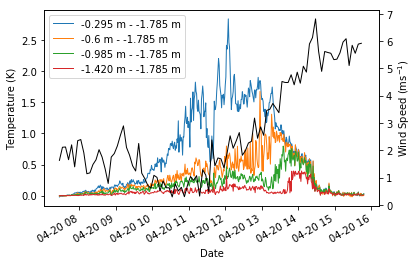

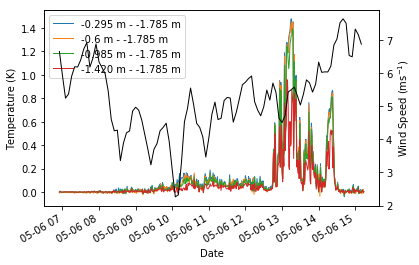

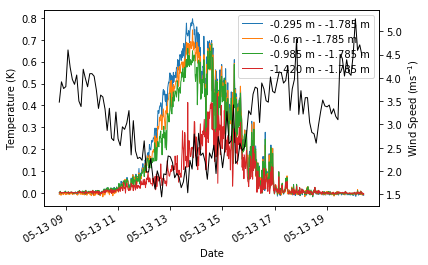

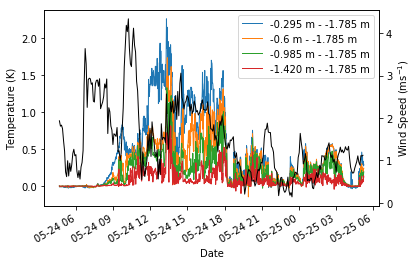

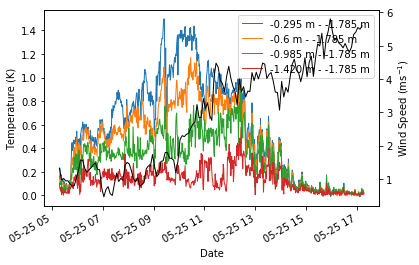

In [128]:
#make plots of times with diurnal warming
#add wind speed to figure
i1save=[12800,35800,46000,61600,63080]
i2save=[13300,36300,46700,63080,63800]
file_str=['q1','q2','q3','q4','q5','q6','q7']
ilen=len(i1save)
for ii in range(0,ilen):
    i1=i1save[ii]
    i2=i2save[ii]
#    t=ds.TIME[0,:].isel(obs=slice(i1,i2)) #UTC time
    t=tlmt.isel(obs=slice(i1,i2)) #local time
    tem2=(tlmt[i1].values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
    tem3=datetime.utcfromtimestamp(tem2)
    day_of_year = tem3.timetuple().tm_yday

    s0=ds.TEMP_CTD_MEAN[0,:].isel(obs=slice(i1,i2))-(ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))) #-273.15)
    s1=ds.sea_water_temperature_logger1_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    s2=ds.sea_water_temperature_logger2_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    s3=ds.sea_water_temperature_logger3_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    #s4=ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    wnd=(ds.UWND_MEAN[0,:].isel(obs=slice(i1,i2))**2+ds.VWND_MEAN[0,:].isel(obs=slice(i1,i2))**2)**.5
    s0mask = np.isfinite(s0)
    s1mask = np.isfinite(s1)
    s2mask = np.isfinite(s2)
    s3mask = np.isfinite(s3)
    #s4mask = np.isfinite(s4)
    wmask = np.isfinite(wnd)
    
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot_date(t[s1mask], s1[s1mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s0mask], s0[s0mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s2mask], s2[s2mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s3mask], s3[s3mask],'-',markersize=.5,lw=1)
    #ax.plot_date(t[s4mask], s4[s4mask],'-',markersize=.5,lw=1)
    ax2.plot_date(t[wmask], wnd[wmask],'k-',markersize=.5,lw=1)
    ax.set(xlabel='Date', ylabel='Temperature (K)')
    ax2.set(ylabel='Wind Speed (ms$^{-1}$)')
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    #ax.fmt_xdata = t.DateFormatter('%Y-%m-%d')
    tem1=ds.sea_water_temperature_logger1_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem2=str(ds.TEMP_CTD_MEAN.installed_height)+' m - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem3=ds.sea_water_temperature_logger2_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem4=ds.sea_water_temperature_logger3_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    ax.legend([tem1,tem2,tem3,tem4])
    fig.savefig(adir+'figs/diurnal/temp_loggers_Dsst_'+str(day_of_year)+'.png')
    plt.show()


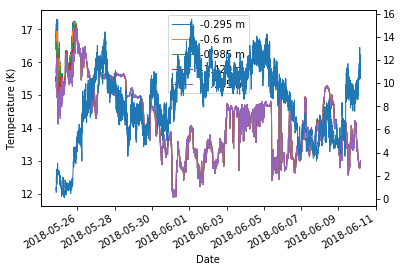

In [129]:
#plot a slice 
#i1save=[12800,35800,46000,61400,62080]
#i2save=[13300,36300,46700,62080,63400]
i1=62080
i2=85592
t=ds.time[0,:].isel(obs=slice(i1,i2))
s0=ds.TEMP_CTD_MEAN[0,:].isel(obs=slice(i1,i2))
s1=ds.sea_water_temperature_logger1_mean[0,:].isel(obs=slice(i1,i2))#-273.15
s2=ds.sea_water_temperature_logger2_mean[0,:].isel(obs=slice(i1,i2))#-273.15
s3=ds.sea_water_temperature_logger3_mean[0,:].isel(obs=slice(i1,i2))#-273.15
s4=ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))#-273.15
wnd=(ds.UWND_MEAN[0,:].isel(obs=slice(i1,i2))**2+ds.VWND_MEAN[0,:].isel(obs=slice(i1,i2))**2)**.5
s0mask = np.isfinite(s0)
s1mask = np.isfinite(s1)
s2mask = np.isfinite(s2)
s3mask = np.isfinite(s3)
s4mask = np.isfinite(s4)
wmask = np.isfinite(wnd)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot_date(t[s1mask], s1[s1mask],'-',markersize=.5,lw=1)
ax.plot_date(t[s0mask], s0[s0mask],'-',markersize=.5,lw=1)
ax.plot_date(t[s2mask], s2[s2mask],'-',markersize=.5,lw=1)
ax.plot_date(t[s3mask], s3[s3mask],'-',markersize=.5,lw=1)
ax.plot_date(t[s4mask], s4[s4mask],'-',markersize=.5,lw=1)
ax2.plot_date(t[wmask], wnd[wmask],'-',markersize=.5,lw=1)
ax.set(xlabel='Date', ylabel='Temperature (K)')
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
#ax.fmt_xdata = t.DateFormatter('%Y-%m-%d')
fig.savefig(adir+'temp_loggers_p3.png')
tem=str(ds.TEMP_CTD_MEAN.installed_height)+' m'
ax.legend([ds.sea_water_temperature_logger1_mean.installed_height,tem,ds.sea_water_temperature_logger2_mean.installed_height,ds.sea_water_temperature_logger3_mean.installed_height,ds.sea_water_temperature_logger4_mean.installed_height])
plt.show()

In [130]:
ds.UWND_MEAN

<xarray.DataArray 'UWND_MEAN' (trajectory: 1, obs: 86839)>
array([[2.85, 4.12, 4.66, ...,  nan,  nan,  nan]])
Coordinates:
  * trajectory  (trajectory) float32 1002.0
    time        (trajectory, obs) datetime64[ns] ...
    latitude    (trajectory, obs) float64 ...
    longitude   (trajectory, obs) float64 ...
Dimensions without coordinates: obs
Attributes:
    standard_name:              eastward_wind
    long_name:                  Eastward wind speed
    units:                      m s-1
    last_calibrated:            2017-05-31
    update_period:              50
    model_product_page:         http://gillinstruments.com/products/anemomete...
    device_name:                Gill Anemometer (172107)
    installed_date:             2017-10-02T18:47:58Z
    nominal_sampling_schedule:  60s on, 240s off, centered at :00
    installed_height:           5.0
    serial_number:              172107
    vendor_name:                Gill
    model_name:                 1590-PK-020

In [131]:
ds.sea_water_temperature_logger4_mean[0:12000].std(ddof=1)

<xarray.DataArray 'sea_water_temperature_logger4_mean' ()>
array(1.920838)

In [132]:
#fig, ax = plt.subplots()
#ax.plot_date(t,s1,'-',markersize=.5,lw=1)
#ax.plot_date(t,s2[5:-4],'-',markersize=.5,lw=1)


In [133]:
print(tlmt[0:5])
ds.time[0:5]

<xarray.DataArray (obs: 5)>
array(['2018-04-11T09:50:24.485376000', '2018-04-11T09:51:23.855616000',
       '2018-04-11T09:52:23.170560000', '2018-04-11T09:53:22.507008000',
       '2018-04-11T09:54:21.812736000'], dtype='datetime64[ns]')
Coordinates:
    trajectory  float32 1002.0
    time        (obs) datetime64[ns] 2018-04-11T18:00:00 2018-04-11T18:01:00 ...
    latitude    (obs) float64 37.81 37.81 37.81 37.81 37.81
    longitude   (obs) float64 -122.4 -122.4 -122.4 -122.4 -122.4
Dimensions without coordinates: obs


<xarray.DataArray 'time' (trajectory: 1, obs: 86839)>
array([['2018-04-11T18:00:00.000000000', '2018-04-11T18:01:00.000000000',
        '2018-04-11T18:02:00.000000000', ..., '2018-06-11T05:47:00.000000000',
        '2018-06-11T05:52:00.000000000', '2018-06-11T05:57:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * trajectory  (trajectory) float32 1002.0
    time        (trajectory, obs) datetime64[ns] ...
    latitude    (trajectory, obs) float64 ...
    longitude   (trajectory, obs) float64 ...
Dimensions without coordinates: obs
Attributes:
    standard_name:  time
    long_name:      time in seconds
    axis:           T

In [134]:
adir

'F:/data/cruise_data/saildrone/baja-2018/'

In [135]:
#fig, ax = plt.subplots()
#for i in range(420,450):
#    ax.plot(tdata[i,:],z,'-',markersize=.5,lw=1)


In [136]:
#resample data to 30 min averages
#profiles = xr.DataArray(tdata, coords={'time': tdata_time,'depth':z}, dims=('time','depth'))
#tlmt[i1].year

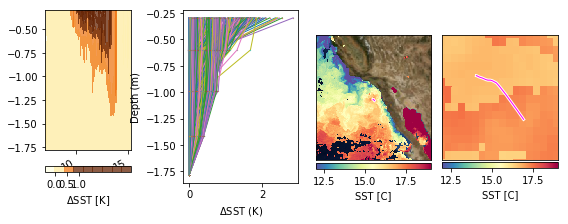

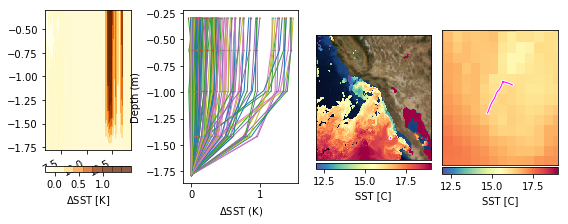

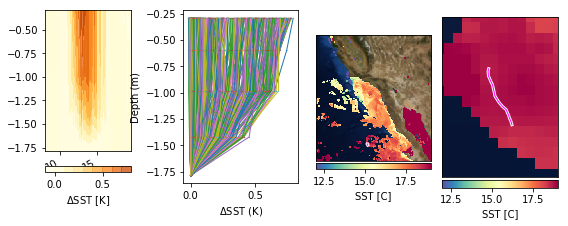

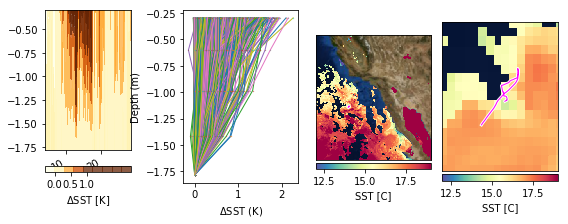

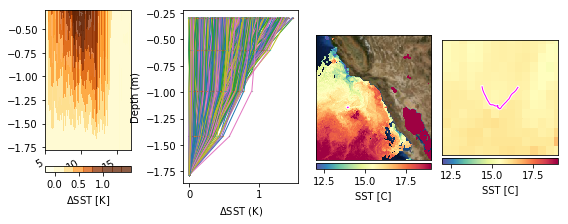

In [11]:
from datetime import datetime, timedelta

#i1save=[12800,35800,46000,61400,62080]
#i2save=[13300,36300,46700,62080,63400]
i1save=[12800,35800,46000,61600,63080]
i2save=[13300,36300,46700,63080,63800]

file_str=['r1','r2','r3','r4','r5','r6','r7']
ilen=len(i1save)
for ii in range(0,ilen):
    i1=i1save[ii]
    i2=i2save[ii]

    tem2=(tlmt[i1].values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
    tem3=datetime.utcfromtimestamp(tem2)
    day_of_year = tem3.timetuple().tm_yday
   
    mn = xr.open_dataset(adir+'sat_data/virs_sst/sst'+str(day_of_year)+'.nc')
    profile_subset = profiles_1min.sel(time=slice(tlmt[i1].values,tlmt[i2].values))
    #tdata_subset = tdata.sel(time=slice(tlmt[i1].values,tlmt[i2].values))
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_axes([0.08, 0.3, 0.15, 0.65])
    #x = profile_subset.time
    #calculate hours from 0:00 on day in LMT
    x = profile_subset.time
    x2=(x.values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
    x3=datetime.utcfromtimestamp(x2[0])
    #print(x3.hour+(x2-x2[0])/60/60)
    x = x3.hour+(x2-x2[0])/60/60
    y = profile_subset.depth
    X, Y = np.meshgrid(x, y)
    c = profile_subset.values.T
    s = ax.contourf(X, Y, c, 8, alpha=.75, cmap=cm.YlOrBr, origin='lower', vmax=1, vmin=0)
        # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    colorbar_ax = fig.add_axes([0.08, 0.2, 0.15, 0.03])
    fig.colorbar(s, cax=colorbar_ax,orientation='horizontal',label='$\Delta$SST [K]',ticks=[0,.5,1])
    #fig.set_label('$\Delta$SST [K]')
    
    ax2 = fig.add_axes([.32, 0.15, 0.2, 0.8])
    for i in range(0,len(profile_subset.time)):
        ax2.plot(profile_subset[i,:].values,z,'-',markersize=.5,lw=1)
        ax2.plot(profile_subset[i,:].values,z,'.',markersize=.5,lw=1)
    ax2.set_xlabel('$\Delta$SST (K)')
    ax2.set_ylabel('Depth (m)')

    #blue marble image of ssts for cruise
    ax3 = fig.add_axes([.55, 0.1, 0.2, 0.85])
    sub_lons=lons_usv[i1:i2].values
    sub_lats=lats_usv[i1:i2].values
    cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap
    m = Basemap(projection='merc', lat_0 = 27, lon_0 = -120,    resolution = 'l', area_thresh = 0.1,    
                                  llcrnrlon=-124, llcrnrlat=27,urcrnrlon=-112, urcrnrlat=38)
    m.bluemarble()
    #    m.fillcontinents(color='grey',lake_color='white')
    lon_grid, lat_grid = np.meshgrid(mn.lon, mn.lat)
    x,y = m(lon_grid,lat_grid)
    cs = m.pcolormesh(x,y, mn.sea_surface_temperature - 273.15, cmap=cmap, vmin = 12, vmax = 19)
    x,y = m(sub_lons,sub_lats)
    m.plot(x,y,'w', linewidth=3)
    m.plot(x,y,color='magenta', linewidth=1)
    m.colorbar(location="bottom",label='SST [C]') # draw colorbar

    #blue marble image of ssts for cruise
    ax4 = fig.add_axes([.77, 0.1, 0.2, 0.85])
    sub_lons=lons_usv[i1:i2].values
    sub_lats=lats_usv[i1:i2].values
    cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap
    m = Basemap(projection='merc', lat_0 = 27, lon_0 = -120,    resolution = 'l', area_thresh = 0.1,    
                                  llcrnrlon=min(sub_lons)-.1, llcrnrlat=min(sub_lats)-.1,urcrnrlon=max(sub_lons)+.1, urcrnrlat=max(sub_lats)+.1)
    m.bluemarble()
    #    m.fillcontinents(color='grey',lake_color='white')
    lon_grid, lat_grid = np.meshgrid(mn.lon, mn.lat)
    x,y = m(lon_grid,lat_grid)
    cs = m.pcolormesh(x,y, mn.sea_surface_temperature - 273.15, cmap=cmap, vmin = 12, vmax = 19)
    x,y = m(sub_lons,sub_lats)
    m.plot(x,y,'w', linewidth=3)
    m.plot(x,y,color='magenta', linewidth=1)
    m.colorbar(location="bottom",label='SST [C]') # draw colorbar
    fig.savefig(adir+'figs/diurnal/temp_loggers_1min_diurnal'+str(day_of_year)+'.png')


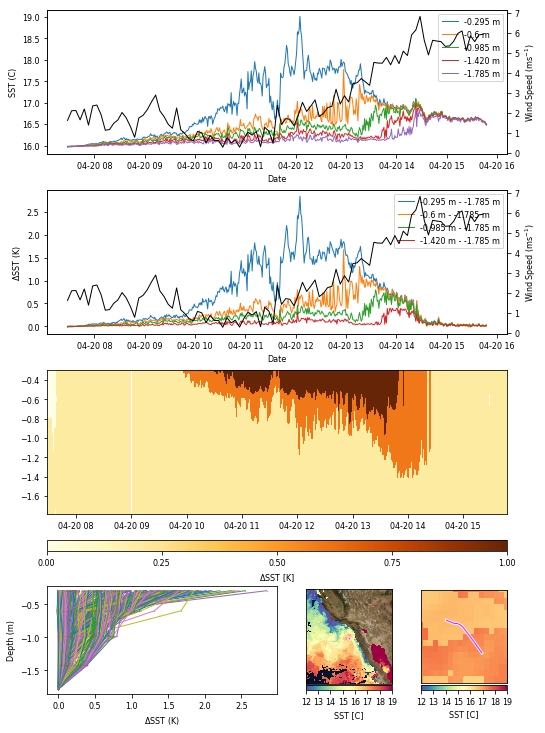

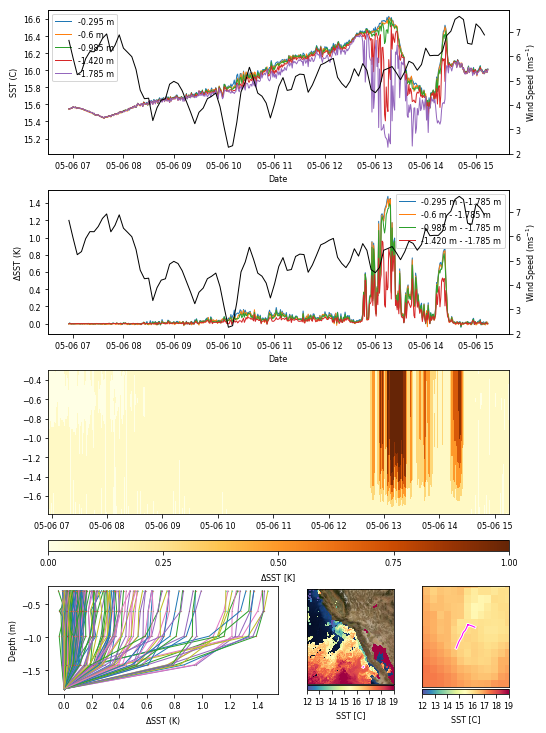

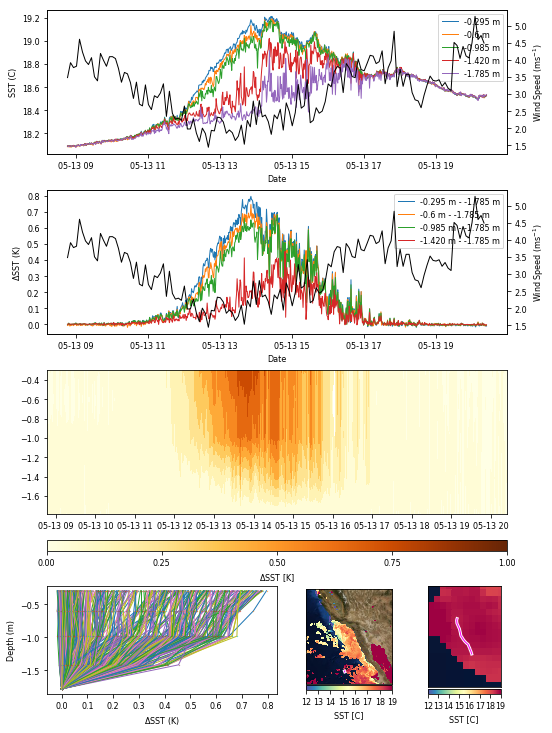

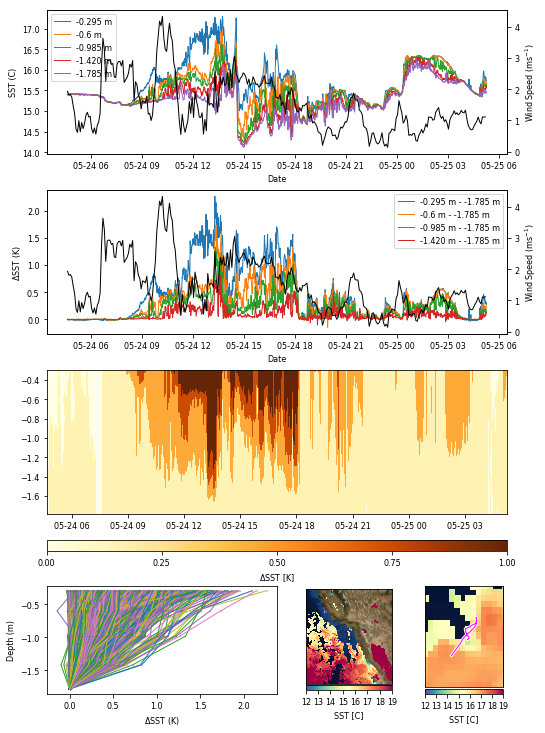

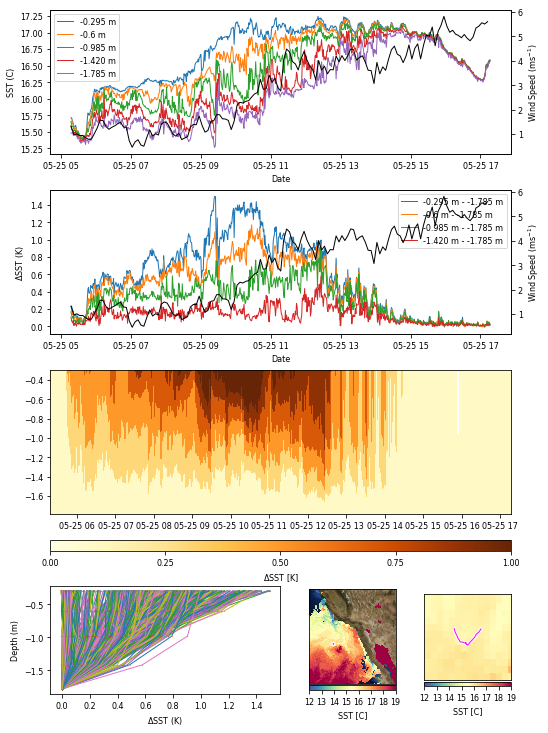

In [146]:
#make plots of times with diurnal warming
#add wind speed to figure
#i1save=[12800,35800,46000,61400,62000]
#i2save=[13300,36300,46700,62080,63400]
i1save=[12800,35800,46000,61600,63080]
i2save=[13300,36300,46700,63080,63800]

file_str=['p1','p2','p3','p4','p5','p6','p7']
ilen=len(i1save)
for ii in range(0,ilen):
    i1=i1save[ii]
    i2=i2save[ii]
#    t=ds.TIME[0,:].isel(obs=slice(i1,i2)) #UTC time
    t=tlmt.isel(obs=slice(i1,i2)) #local time
    tem2=(tlmt[i1].values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
    tem3=datetime.utcfromtimestamp(tem2)
    day_of_year = tem3.timetuple().tm_yday

    s0=ds.TEMP_CTD_MEAN[0,:].isel(obs=slice(i1,i2))
    s1=ds.sea_water_temperature_logger1_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s2=ds.sea_water_temperature_logger2_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s3=ds.sea_water_temperature_logger3_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    s4=ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))#-273.15
    wnd=(ds.UWND_MEAN[0,:].isel(obs=slice(i1,i2))**2+ds.VWND_MEAN[0,:].isel(obs=slice(i1,i2))**2)**.5
    s0mask = np.isfinite(s0)
    s1mask = np.isfinite(s1)
    s2mask = np.isfinite(s2)
    s3mask = np.isfinite(s3)
    s4mask = np.isfinite(s4)
    wmask = np.isfinite(wnd)
    
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_axes([0.1, 0.8, 0.8, 0.2])
#    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot_date(t[s1mask], s1[s1mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s0mask], s0[s0mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s2mask], s2[s2mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s3mask], s3[s3mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s4mask], s4[s4mask],'-',markersize=.5,lw=1)
    ax2.plot_date(t[wmask], wnd[wmask],'k-',markersize=.5,lw=1)
    ax.set(xlabel='Date', ylabel='SST (C)')
    ax2.set(ylabel='Wind Speed (ms$^{-1}$)')
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    #ax.fmt_xdata = t.DateFormatter('%Y-%m-%d')
    tem=str(ds.TEMP_CTD_MEAN.installed_height)+' m'
    ax.legend([ds.sea_water_temperature_logger1_mean.installed_height,tem,ds.sea_water_temperature_logger2_mean.installed_height,ds.sea_water_temperature_logger3_mean.installed_height,ds.sea_water_temperature_logger4_mean.installed_height])

    
    s0=ds.TEMP_CTD_MEAN[0,:].isel(obs=slice(i1,i2))-(ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))) #-273.15)
    s1=ds.sea_water_temperature_logger1_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    s2=ds.sea_water_temperature_logger2_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    s3=ds.sea_water_temperature_logger3_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    #s4=ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))-ds.sea_water_temperature_logger4_mean[0,:].isel(obs=slice(i1,i2))
    wnd=(ds.UWND_MEAN[0,:].isel(obs=slice(i1,i2))**2+ds.VWND_MEAN[0,:].isel(obs=slice(i1,i2))**2)**.5
    s0mask = np.isfinite(s0)
    s1mask = np.isfinite(s1)
    s2mask = np.isfinite(s2)
    s3mask = np.isfinite(s3)
    #s4mask = np.isfinite(s4)
    wmask = np.isfinite(wnd)
    
    #fig, ax = plt.subplots()
    ax = fig.add_axes([0.1, 0.55, 0.8, 0.2])
    ax2 = ax.twinx()
    ax.plot_date(t[s1mask], s1[s1mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s0mask], s0[s0mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s2mask], s2[s2mask],'-',markersize=.5,lw=1)
    ax.plot_date(t[s3mask], s3[s3mask],'-',markersize=.5,lw=1)
    #ax.plot_date(t[s4mask], s4[s4mask],'-',markersize=.5,lw=1)
    ax2.plot_date(t[wmask], wnd[wmask],'k-',markersize=.5,lw=1)
    ax.set(xlabel='Date', ylabel='$\Delta$SST (K)')
    ax2.set(ylabel='Wind Speed (ms$^{-1}$)')
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    #ax.fmt_xdata = t.DateFormatter('%Y-%m-%d')
    tem1=ds.sea_water_temperature_logger1_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem2=str(ds.TEMP_CTD_MEAN.installed_height)+' m - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem3=ds.sea_water_temperature_logger2_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    tem4=ds.sea_water_temperature_logger3_mean.installed_height+' - '+ds.sea_water_temperature_logger4_mean.installed_height
    ax.legend([tem1,tem2,tem3,tem4])
    
    
    tem2=(tlmt[i1].values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
    tem3=datetime.utcfromtimestamp(tem2)
    day_of_year = tem3.timetuple().tm_yday
   
    mn = xr.open_dataset(adir+'sat_data/virs_sst/sst'+str(day_of_year)+'.nc')
    profile_subset = profiles_1min.sel(time=slice(tlmt[i1].values,tlmt[i2].values))
    #tdata_subset = tdata.sel(time=slice(tlmt[i1].values,tlmt[i2].values))
    #fig = plt.figure(figsize=(8,3))
    ax = fig.add_axes([0.1, 0.3, 0.8, 0.2])
    #x = profile_subset.time
    #calculate hours from 0:00 on day in LMT
    x = profile_subset.time
    #x2=(x.values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
    #x3=datetime.utcfromtimestamp(x2[0])
    #print(x3.hour+(x2-x2[0])/60/60)
    #x = x3.hour+(x2-x2[0])/60/60
    y = profile_subset.depth
    X, Y = np.meshgrid(x, y)
    c = profile_subset.values.T
    s = ax.contourf(X, Y, c, 8, cmap=cm.YlOrBr, origin='lower', vmax=1, vmin=0)
        # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    m = plt.cm.ScalarMappable(cmap=cm.YlOrBr)
    m.set_array(c)
    m.set_clim(0., 1.)
    colorbar_ax = fig.add_axes([0.1, 0.248, 0.8, 0.015])
    fig.colorbar(m, cax=colorbar_ax,orientation='horizontal',label='$\Delta$SST [K]',ticks=[0,.25,.5,.75,1])
    #fig.set_label('$\Delta$SST [K]')
    
    ax2 = fig.add_axes([.1, 0.05, 0.4, 0.15])
    for i in range(0,len(profile_subset.time)):
        ax2.plot(profile_subset[i,:].values,z,'-',markersize=.5,lw=1)
        ax2.plot(profile_subset[i,:].values,z,'.',markersize=.5,lw=1)
    ax2.set_xlabel('$\Delta$SST (K)')
    ax2.set_ylabel('Depth (m)')

    #blue marble image of ssts for cruise
    ax3 = fig.add_axes([.55, 0.05, 0.15, 0.15])
    sub_lons=lons_usv[i1:i2].values
    sub_lats=lats_usv[i1:i2].values
    cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap
    m = Basemap(projection='merc', lat_0 = 27, lon_0 = -120,    resolution = 'l', area_thresh = 0.1,    
                                  llcrnrlon=-124, llcrnrlat=27,urcrnrlon=-112, urcrnrlat=38)
    m.bluemarble()
    #    m.fillcontinents(color='grey',lake_color='white')
    lon_grid, lat_grid = np.meshgrid(mn.lon, mn.lat)
    x,y = m(lon_grid,lat_grid)
    cs = m.pcolormesh(x,y, mn.sea_surface_temperature - 273.15, cmap=cmap, vmin = 12, vmax = 19)
 #   cs = m.pcolormesh(x,y, mn.sea_surface_temperature , cmap=cmap, vmin = 12, vmax = 19)
    x,y = m(sub_lons,sub_lats)
    m.plot(x,y,'w', linewidth=3)
    m.plot(x,y,color='magenta', linewidth=1)
    m.colorbar(location="bottom",label='SST [C]') # draw colorbar

    #blue marble image of ssts for cruise
    ax4 = fig.add_axes([.75, 0.05, 0.15, 0.15])
    sub_lons=lons_usv[i1:i2].values
    sub_lats=lats_usv[i1:i2].values
    cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap
    m = Basemap(projection='merc', lat_0 = 27, lon_0 = -120,    resolution = 'l', area_thresh = 0.1,    
                                  llcrnrlon=min(sub_lons)-.1, llcrnrlat=min(sub_lats)-.1,urcrnrlon=max(sub_lons)+.1, urcrnrlat=max(sub_lats)+.1)
    m.bluemarble()
    #    m.fillcontinents(color='grey',lake_color='white')
    lon_grid, lat_grid = np.meshgrid(mn.lon, mn.lat)
    x,y = m(lon_grid,lat_grid)
#    cs = m.pcolormesh(x,y, mn.sea_surface_temperature , cmap=cmap, vmin = 12, vmax = 19)
    cs = m.pcolormesh(x,y, mn.sea_surface_temperature - 273.15, cmap=cmap, vmin = 12, vmax = 19)
    x,y = m(sub_lons,sub_lats)
    m.plot(x,y,'w', linewidth=3)
    m.plot(x,y,color='magenta', linewidth=1)
    m.colorbar(location="bottom",label='SST [C]') # draw colorbar
#    fig.savefig(adir+'temp_loggers__diurnal'+str(day_of_year)+'.png')
    
    
    fig.savefig(adir+'figs/diurnal/temp_loggers_1min_all_'+str(day_of_year)+'.png')
 #   plt.show()
    
    
    #fig.savefig(adir+'temp_loggers_sst_'+str(day_of_year)+'.png')
    #plt.show()


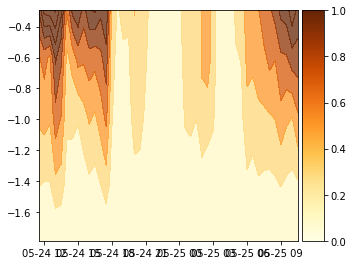

In [139]:
profile_subset = profiles.sel(time=slice(tlmt[i1].values,tlmt[i2].values))
#tdata_subset = tdata.sel(time=slice(tlmt[i1].values,tlmt[i2].values))
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8])
x = profile_subset.time
y = profile_subset.depth
X, Y = np.meshgrid(x, y)
c = profile_subset.values.T
s = ax.contourf(X, Y, c, 8, alpha=.75, cmap=cm.YlOrBr, origin='lower', vmax=1, vmin=0)
m = plt.cm.ScalarMappable(cmap=cm.YlOrBr)
m.set_array(c)
m.set_clim(0., 1.)
colorbar_ax = fig.add_axes([0.71, 0.1, 0.05, 0.8])
fig.colorbar(m, cax=colorbar_ax)

#ax2 = fig.add_axes([.95, 0.1, 0.3, 0.8])
#for i in range(0,len(profile_subset.time)):
#    ax2.plot(profile_subset[i,:].values,z,'-',markersize=.5,lw=1)


In [140]:

x = profile_subset.time
x2=(x.values-np.datetime64('1970-01-01'))/np.timedelta64(1,'s')
x3=datetime.utcfromtimestamp(x2[0])
print(x3.hour+(x2-x2[0])/60/60)


[11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5
 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5
 25.  25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.  30.5 31.  31.5
 32.  32.5 33.  33.5 34. ]


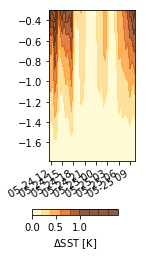

In [141]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_axes([0.08, 0.3, 0.15, 0.7])
x = profile_subset.time
y = profile_subset.depth
X, Y = np.meshgrid(x, y)
c = profile_subset.values.T
s = ax.contourf(X, Y, c, 8, alpha=.75, cmap=cm.YlOrBr, origin='lower', vmax=1, vmin=0)
        # rotate and align the tick labels so they look better
fig.autofmt_xdate()
colorbar_ax = fig.add_axes([0.05, 0.05, 0.15, 0.03])
fig.colorbar(s, cax=colorbar_ax,orientation='horizontal',label='$\Delta$SST [K]',ticks=[0,.5,1])
font = {'size'   : 8}
matplotlib.rc('font', **font)